# Olivine Diffusion

Olivine is one of the most important mineral composition the upper mantle and controlling its rheology as well as seismic and eletric properties. Several studies pointed the role of water on the properties of olivine, and, hence, on those of the mantle. Despite such importance, it turns out that we do not have a consensus on the way water is stored and diffuse in olivine, as this is a very complex process.

Water diffusion in olivine seems to be linked to its diffusion in various point defects, namely Si and Mg vacancies as well as in Mg vacancies in association with trivalent cations like Al$^{3+}$ or Fe$^{3+}$, or forming a Ti-clinohumite like point defect.

In this notebook, we will see if we can see such association in a forsterite crystal that has been hydroxylated during an experiment in a piston-cylinder. The experiment lasted 48 hours at 1400 °C and 1.5 GPa. How water diffuses in those conditions in the Fo crystal ?

**This is a real worl problem, published in**

*C. Le Losq, M. C. Jollands, P. M. E. Tollan, R. Hawkins, H. St. C. O’Neill, Point defect populations of forsterite revealed by two-stage metastable hydroxylation experiments. Contrib Mineral Petrol. 174, 53 (2019).*


# Diffusion in olivine

We can study this question as an speudo-equilibrium is rapidly established at the boundary of our olivine crystal, imposing a concentration $c_0$ at the boundary (faces of our crystal, a cube of 1x1x1 mm)

To study the diffusive process, we can use the Fick equations. In particular, the second law of Fick allows describing the variation of the concentration of a substance in a media given time. In one dimension, we have:

$ \frac{\partial c}{\partial t} $ = D $ \frac{\partial^2 c }{\partial x^2} $ .   (eq. 1)

Assuming a constant concentration $c_0$ at $x$ = 0, a simple solution is given by : 

$ c(x,t) = c_0 \text{erfc}({\frac{x}{2\sqrt{Dt}}})$ . (eq. 2)

Represent below the profil of concentration at t = 0 h, t = 12 h, t = 24 h and t = 48 h.

*Tips: (1) erfc function is provided by scipy.special; (2) t=0 does not work, but you can use t=0.000001 as an approximation.*

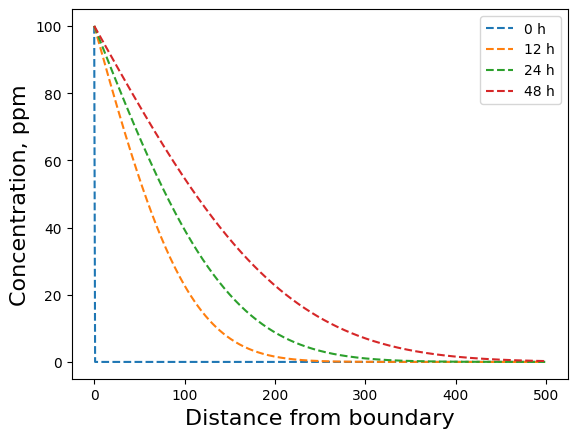

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import curve_fit

from scipy.special import erfc

def diff(x,t,D,c0):
    """1D solution to Fick second law
    
    Parameters
    ----------
    x : distance in microns
    
    t : time in h
    
    D : diffusion coefficient in log10 m2 s-1
    
    c0 : concentration at the border in ppm
    
    Returns
    -------
    c : concentration at distance x
    """
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t*3600)))

x = np.arange(0,500,1.0) # Notre profil de la bordure au centre

x0 = 100.0 # ppm, la concentration en eau à la bordure

D = -13.1 # m2 s-1, le coefficient de diffusion à la température de travail, 1400 °C

plt.plot(x, diff(x,0.00001,D,100.0),"--",label="0 h")
plt.plot(x, diff(x,12,D,100.0),"--",label="12 h")
plt.plot(x, diff(x,24,D,100.0),"--",label="24 h")
plt.plot(x, diff(x,48,D,100.0),"--",label="48 h")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()

# Application to real-world data

You will find two files with concentrations in Al, Fe, Sc... measured by LA-ICP-MS after one experiments. Hit: conditions are in the filename...

Using the equation presented above, try to : 
- fit those data and determine the diffusion coefficients of those elements; 
- provide sensible errors bars for the parameters, and propagate them on the fit solution. 
- Re-do the above graph for all elements with errors bars

Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')
Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')


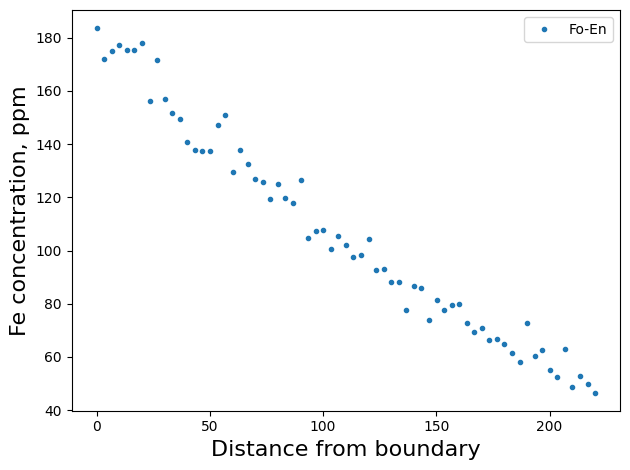

In [2]:
#
# Loading the data
#
data_1400C_192h_FoEn = pd.read_csv("16C_ICP1_1400C_axisC_192h_FoEn.csv")
print(data_1400C_192h_FoEn.columns)
data_1400C_192h_FoPer = pd.read_csv("16B_ICP2_1400C_axisC_192h_FoPer.csv")
print(data_1400C_192h_FoPer.columns)

#
# The data we want to fit
#
t_exp = 192.0*3600
x_obs_1 = data_1400C_192h_FoEn.Distance.values
y_obs_1 = data_1400C_192h_FoEn.Fe_ppm_m57.values
ese_obs_1 = 7.0*np.ones(len(x_obs_1))

#
# Plotting my data
#
plt.plot(x_obs_1,y_obs_1,".",label="Fo-En")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

# Problem resolution

## Forward model

$$ C(x) = C(0) \times erfc(\frac{x}{2\sqrt{Dt}})$$

Do not forget to scale things !

    - D in log10
    - x in micrometers, so multiply by 1e-6 in the function

In [3]:
def forward_model(x, D, c0):
    """This is the foward model: solution in 1D of Fick diffusion
    
    Parameters
    ----------
    x : 1d array
        the distance in microns
    D : float
        the diffusion coefficient, in log10 m2 s-1
    c0 : float
        the concentration at the border
        
    Returns
    -------
    c(x) : array
        the array of the concentrations at x
    """
    t = 192.0*3600 # time is defined here
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))

## First, we can use curvefit

Fe diffusion coefficient is: -13.55
Associated error is: 0.01


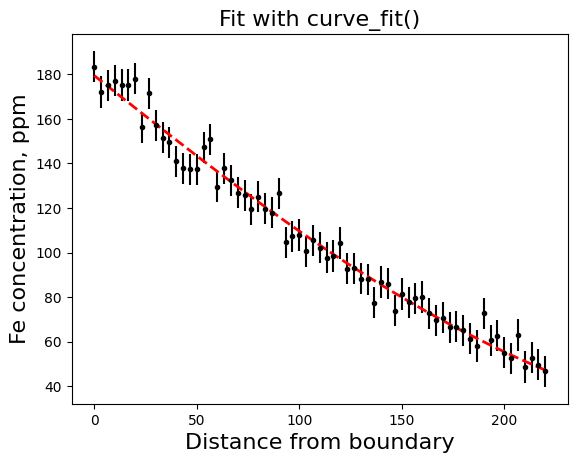

In [4]:
# fit, ponderated least squares (error of 7 ppm on Fe measurements)
popt, pcov = curve_fit(forward_model, x_obs_1, y_obs_1, sigma = ese_obs_1, p0=[-14., 180.])

# error calculation, see scipy.optimize help
perr = np.sqrt(np.diag(pcov))

# make a figure
plt.figure()
plt.errorbar(x_obs_1,y_obs_1,yerr=7.0,fmt=".",color="k",label="data")
plt.plot(x_obs_1, forward_model(x_obs_1, *popt), "r--", linewidth=2.0, label="curvefit model")

plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.title("Fit with curve_fit()",fontsize=16)

print("Fe diffusion coefficient is: {:0.2f}".format(popt[0]))
print("Associated error is: {:0.2f}".format(perr[0]))

## Now, we can also use minimize()

See help [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

We need to redefine an objective function, to pass our forward model and to use minimize() for the fit.

We will compare least-squares with least absolute deviations (LAD).


#### LEAST SQUARE VALUES ####
My diffusion coefficient is: -13.55

 #### LAD VALUES #### 
My diffusion coefficient is: -13.56


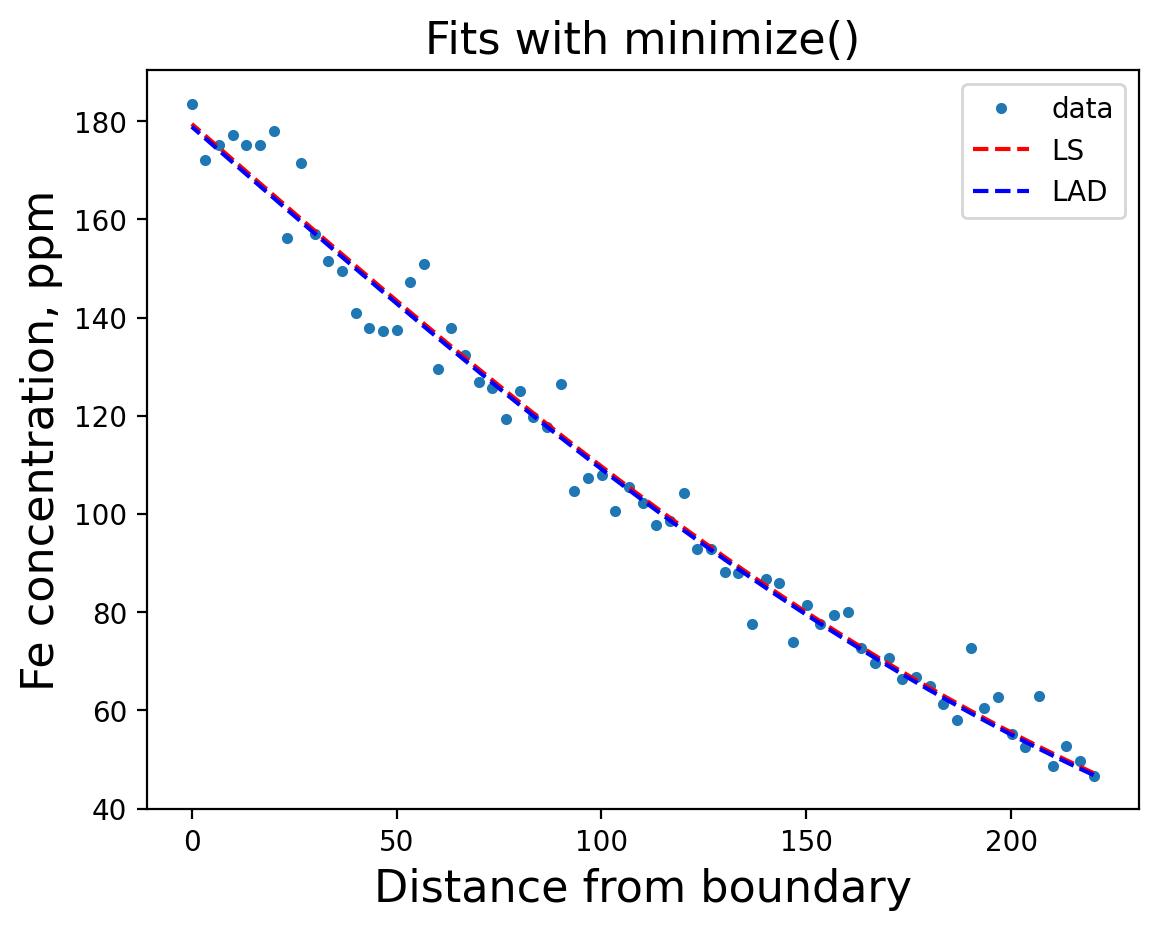

In [5]:


from scipy.optimize import minimize

def least_squares(p, x, y, yerr=1.0):
    """the least square objective function"""
    model_values = forward_model(x, p[0], p[1])
    criterion = np.sum((y-model_values)**2/yerr**2) # least squares criterion
    return criterion

def LAD(p, x, y, yerr=1.0):
    """the least absolute deviation objective function"""
    model_values = forward_model(x, p[0], p[1])
    criterion = np.sum(np.abs((y-model_values)/yerr))
    return criterion

# the fit using least-squares
result_LS = minimize(least_squares, [-14.,200.], args=(x_obs_1,y_obs_1,ese_obs_1))

# the fit using LAD
result_LAD = minimize(LAD, [-14.,200.], args=(x_obs_1,y_obs_1,ese_obs_1))

# make a figure
plt.figure(dpi=200)
plt.plot(x_obs_1,y_obs_1,".",label="data")
plt.plot(x_obs_1, forward_model(x_obs_1, *result_LS['x']), "r--", label="LS")
plt.plot(x_obs_1, forward_model(x_obs_1, *result_LAD['x']), "b--", label="LAD")
plt.legend()

plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.title("Fits with minimize()",fontsize=16)

# print stuffs
print("#### LEAST SQUARE VALUES ####")
print("My diffusion coefficient is: {:0.2f}".format(result_LS['x'][0]))

print("\n #### LAD VALUES #### ")
print("My diffusion coefficient is: {:0.2f}".format(result_LAD['x'][0]))

## Fit with a global optimization algorithm, e.g. differential evolution

The above fit will fail if one does not know well the starting values p0. In this case, it is better to use a global optimization algorithm, like differential evolution. Let's try it below:

#### LEAST SQUARE VALUES ####
My diffusion coefficient is: -13.55

 #### LAD VALUES #### 
My diffusion coefficient is: -13.56


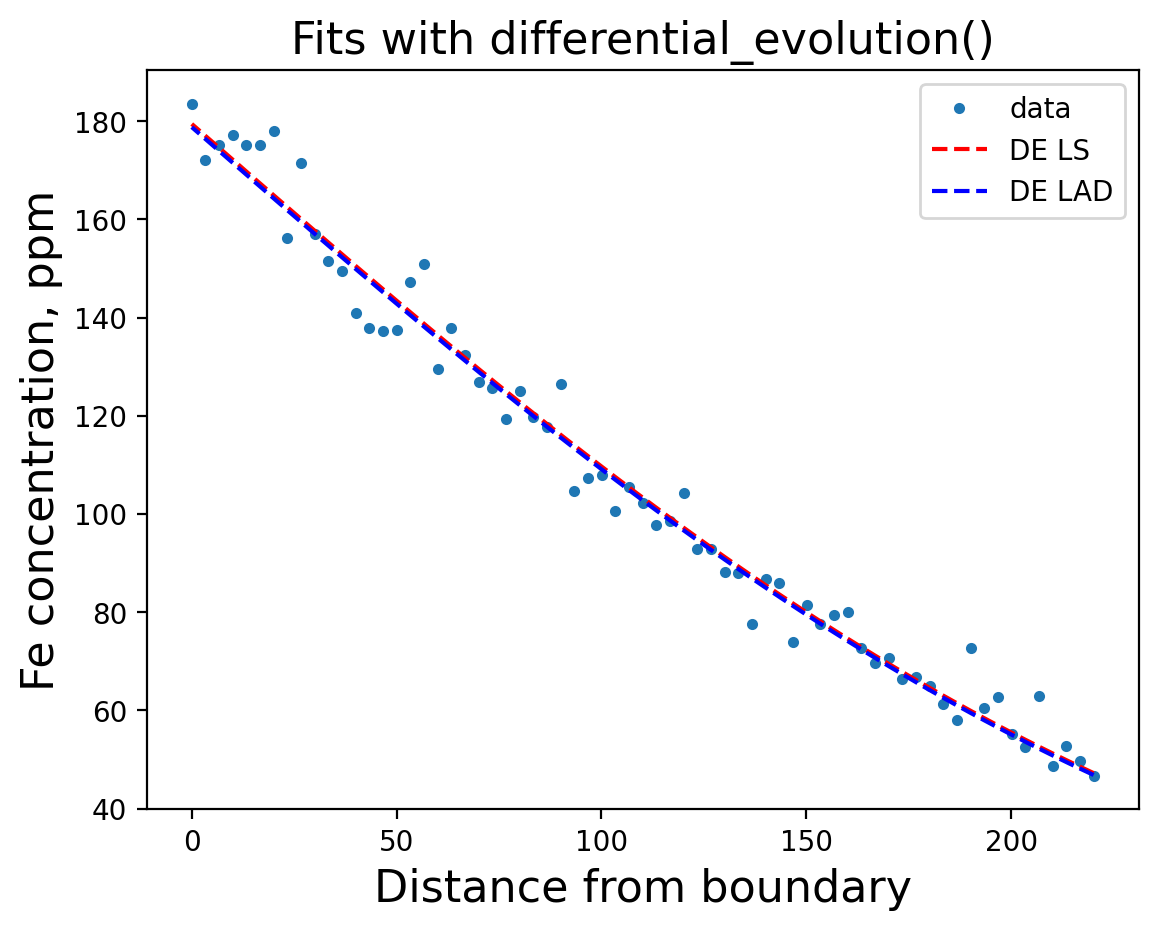

In [6]:
from scipy.optimize import differential_evolution # we import the method here

# the code is essentially the same, except that we provide seach boundaries for the parameters, see the docs
result_LS = differential_evolution(least_squares, [[-30., 0.], [0,1000.]], args=(x_obs_1,y_obs_1,ese_obs_1))
result_LAD = differential_evolution(LAD, [[-30., 0.], [0,1000.]], args=(x_obs_1,y_obs_1,ese_obs_1))

# make a figure
plt.figure(dpi=200)
plt.plot(x_obs_1,y_obs_1,".",label="data")
plt.plot(x_obs_1, forward_model(x_obs_1, *result_LS['x']), "r--", label="DE LS")
plt.plot(x_obs_1, forward_model(x_obs_1, *result_LAD['x']), "b--", label="DE LAD")
plt.legend()

plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.title("Fits with differential_evolution()",fontsize=16)

print("#### LEAST SQUARE VALUES ####")
print("My diffusion coefficient is: {:0.2f}".format(result_LS['x'][0]))

print("\n #### LAD VALUES #### ")
print("My diffusion coefficient is: {:0.2f}".format(result_LAD['x'][0]))

## Estimating the errors, alternative 1 : bootstrapping (with replacement a.k.a. non-parametric)

Below we will perform a bootstrap to resample our dataset, fit the subsamples many times, and get estimates from those fits.

Read [this](https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/) blog post for instance to get more information about bootstrapping.

Text(0.5, 1.0, 'Bootstrapping')

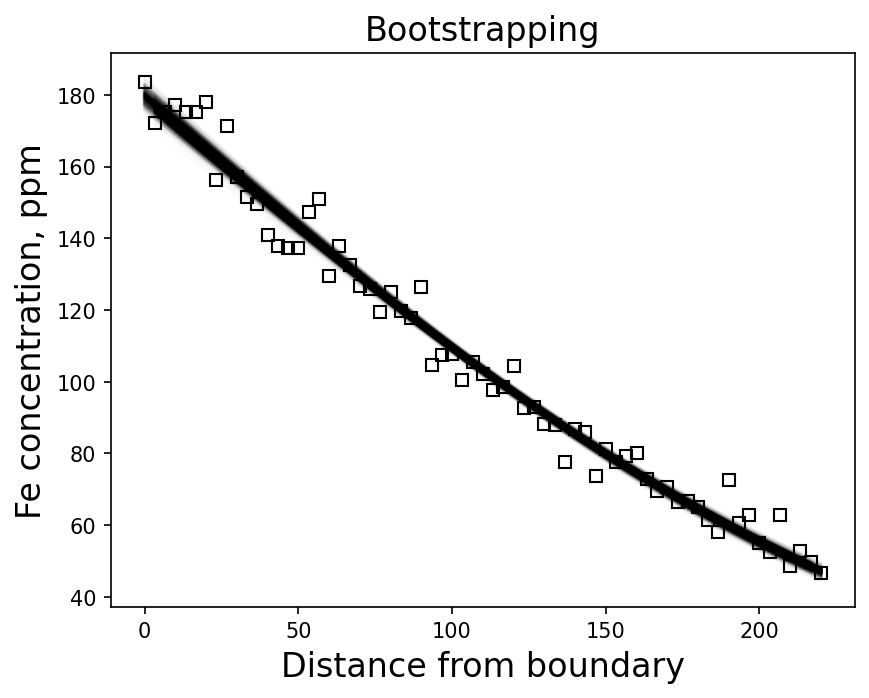

In [7]:
# put x and y together
data_ = np.vstack((x_obs_1, y_obs_1)).T

# variable for the number of iterations
n_iter = 1000

# create an array to record model values
model_bootstrap = []

# plot the original data
plt.figure(dpi=150)
plt.plot(data_[:,0], data_[:,1],"ks", mfc="none")

# below we generate n_iter subsamples and fit them
# we then store the estimated parameters in model_bootstrap
# this will allow us to get an estimate later of the distribution of model parameters
for i in range(n_iter):
    # how many lines
    n = len(x_obs_1)
    # random lines selection
    random_lines = np.random.randint(0,n, size=n)
    # draw subsample
    subsample = data_[random_lines,:]
    
    #defining the fitting data in two vectors
    x_fit = subsample[:,0]
    y_fit = subsample[:,1]

    # fit 
    result_LS = minimize(least_squares, [-13.5,190.], args=(x_fit,y_fit))
    
    # appending the best parameters to my recording list
    model_bootstrap.append(result_LS['x'])
    
    # showing the predicted curve
    plt.plot(np.sort(x_fit), forward_model(np.sort(x_fit),*result_LS['x']),"k-", alpha=0.01)
    
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.title("Bootstrapping",fontsize=16)

Below we transform `model_bootstrap` in a numpy array for practical reasons, and then we plot histograms for D and c0. We can compare their distribution with the Gaussian distribution that can be drawn using the `popt` and `pcov` arrays from curve_fit().




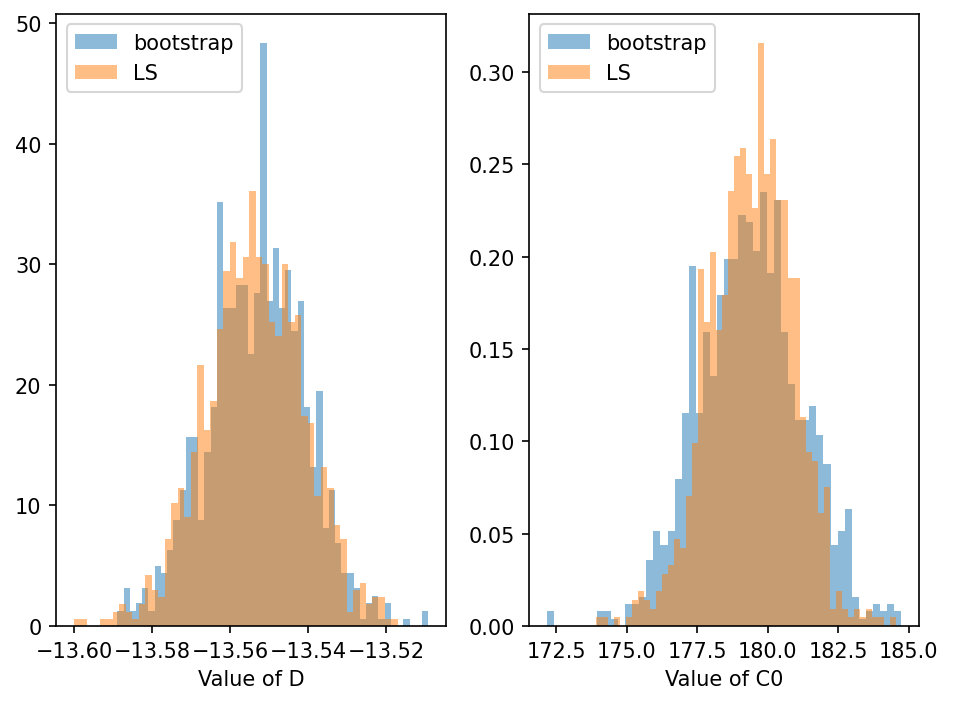

In [8]:
# WE transform the list into an array
model_bootstrap_array = np.array(model_bootstrap)

# plotting histograms
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.hist(model_bootstrap_array[:,0].ravel(),density=True, bins=50,label="bootstrap", alpha=0.5)
plt.hist(np.random.normal(loc=popt[0],scale=perr[0],size = n_iter),
         bins = 50,density=True,label="LS", alpha=0.5)

plt.xlabel("Value of D")
plt.legend()

plt.subplot(1,2,2)
plt.hist(model_bootstrap_array[:,1].ravel(), density=True,bins=50,label="bootstrap", alpha=0.5)
plt.hist(np.random.normal(loc=popt[1],scale=perr[1],size = n_iter),
         bins = 50,density=True,label="LS", alpha=0.5)

plt.xlabel("Value of C0")
plt.legend()
plt.tight_layout()

## Estimating the errors, alternative 2 : MCMC

Now, we could also re-use the code from the notebook 7 to perform a MCMC fit of the data. Let's reuse the `MCMC` function "home-made". We basically just need to modify the `logprior`function to be able to run the code!

In [9]:
def lognormal(x,mu,std):
    var = std**2
    return -0.5*((x-mu)**2/var + np.log(2.0*np.pi*var))

def logprior(theta):
    """log prior probability function for the parameters
    
    This implementation uses a uniform distribution
    
    Parameters
    ==========
    theta : list
        the parameters
        
    Returns
    =======
    logprob_prior : the estimated probability of the prior values
    
    """
    D ,c0 = theta
    
    if -20 < D < -10 \
    and 0 < c0 < 1000:
        return 0.0
    else:
        return -np.inf
    
def loglike(theta,x,y,yerr):
    """log likelyhood function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_likely : float
        the estimated likelyhood of the a model compared to observations
    
    """
    model = forward_model(x,*theta)
    ln_likely = np.sum(lognormal(y,model,yerr))
    return ln_likely

def logjoint(theta, x,y, yerr):
    """joint probability function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_prob : float
        the total likelyhood of a model compared to observations
    
    """
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta,x,y,yerr)


def mcmc(x,y,yerr,theta_start,scales,nb_iter):
    """MCMC Metropolis Hasting function to fit simple data
    
    Parameters
    ==========
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
    theta_prior : list
        the estimates of model parameters
    scales : list
        scaling factor for perturbating the parameters
    nb_iter : int
        number of iterations to perform = number of sampled models
        
    Returns
    =======
    theta_record : ndarray, shape = (nb_iter,size(theta_prior))
        the estimates of model parameters
    logrecord : 1D array
        the log probabilities of the nb_iter models
    acceptance_rate : 1D array
        the acceptance rate for each parameter
        
    """
    logrecord = np.zeros(nb_iter)
    theta_record = np.zeros((nb_iter,len(theta_start)))
    
    # to calculated acceptance rate
    accepted = 0
    
    # the starting parameters and logrecord
    logrecord[0] = logjoint(theta_start,x,y,yerr)
    theta_record[0,:] = theta_start
    
    i = 1
    while i < nb_iter:
        
        # we perturbate parameters
        theta_0 = theta_record[i-1,:] + scales*np.random.randn(2)
        # we calculate the associated log prob
        logprob_theta0 = logjoint(theta_0,x,y,yerr)
        # and the ratio (subtraction as we are in log) with the old logprob
        alpha = logprob_theta0 - logrecord[i-1]
        
        if np.exp(alpha) > np.random.rand(): # if our probability is actually higher than the previous
            logrecord[i] = logprob_theta0
            theta_record[i,:] = theta_0
            accepted = accepted + 1
        else: # otherwise we stay at the same position
            logrecord[i] = logrecord[i-1]
            theta_record[i,:] = theta_record[i-1,:]
            
        i += 1 # incrementing i as well as the number of tested models
            
    # calculation of acceptance rates
    acceptance_rate = accepted/(nb_iter-1)
    
    # results are returned
    return theta_record, logrecord, acceptance_rate  

Now we define things like the starting values, and run the code.

In [10]:
# scaling for the perturbations
scales = [0.5e-1,1.0]

# number of iterations and chains
nb_iter= 20000
nb_chains = 5

# lists to record stuffs
chains_theta = []
chains_logrecord = []
chains_acceptance = []

# we loop for chains
for i in range(nb_chains):
    
    print("Chain "+str(i))
    # we select starting point randomly in a plausible region for each chain: 
    theta_start = [float(np.random.randint(-20, -10)), float(np.random.randint(100, 300))]
    print("Parameters starting value: "+str(theta_start)) 
    print("")
    
    # running ou MH algorithm
    theta_mcmc, logrecord_mcmc, acceptance_rate = mcmc(x_obs_1,y_obs_1,ese_obs_1,theta_start,scales,nb_iter)
    
    # recording results in lists
    chains_theta.append(theta_mcmc)
    chains_logrecord.append(logrecord_mcmc)
    chains_acceptance.append(acceptance_rate)
    


Chain 0
Parameters starting value: [-19.0, 172.0]

Chain 1
Parameters starting value: [-13.0, 148.0]

Chain 2
Parameters starting value: [-14.0, 264.0]

Chain 3
Parameters starting value: [-16.0, 161.0]

Chain 4
Parameters starting value: [-13.0, 140.0]



mean acceptance rates are:
[0.25396269813490674, 0.2513125656282814, 0.2533626681334067, 0.25081254062703134, 0.25416270813540676]


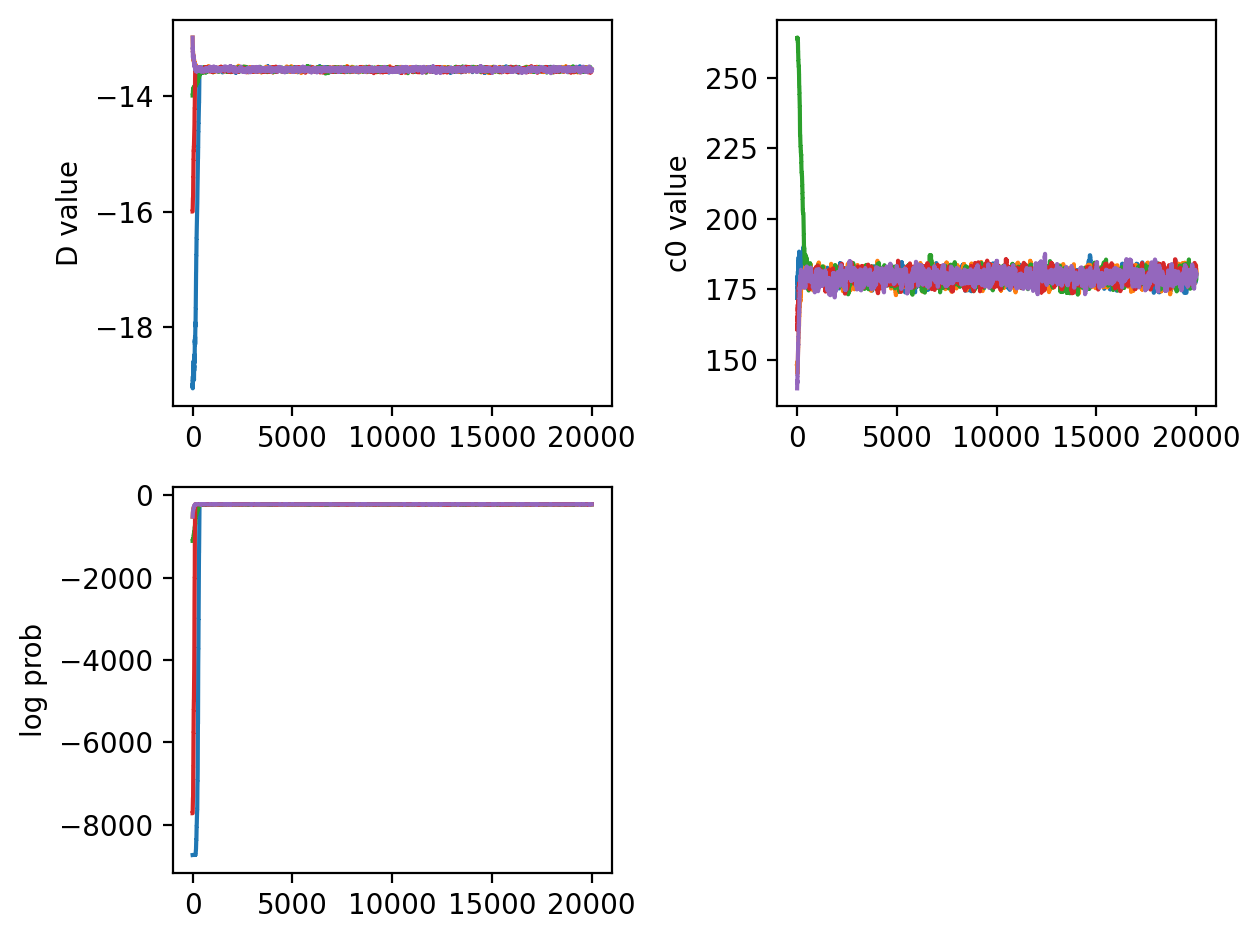

In [11]:
plt.figure(dpi=200)

plt.subplot(2,2,1)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,0])
plt.ylabel("D value")

plt.subplot(2,2,2)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,1])
plt.ylabel("c0 value")

plt.subplot(2,2,3)
for i in range(nb_chains):
    plt.plot(chains_logrecord[i])
plt.ylabel("log prob")


plt.tight_layout()

# look at acceptance rates
print("mean acceptance rates are:")
print(chains_acceptance)

We converge quite quickly. We can throw away the first 1000 iterations, based on the observation of the graphs.

In [12]:
Burnin = 500

plt.figure()
samples_MH=[]
for i in range(nb_chains):
    samples_MH.append(chains_theta[i][Burnin:-1,:])
    
samples_MH = np.concatenate(samples_MH)

D_mcmc = np.median(samples_MH[:,0])
c0_mcmc = np.median(samples_MH[:,1])
nb_drawn_samples = len(samples_MH)

<Figure size 640x480 with 0 Axes>

With the library `corner` we can observe the histograms of the parameters, to observe any covariance.

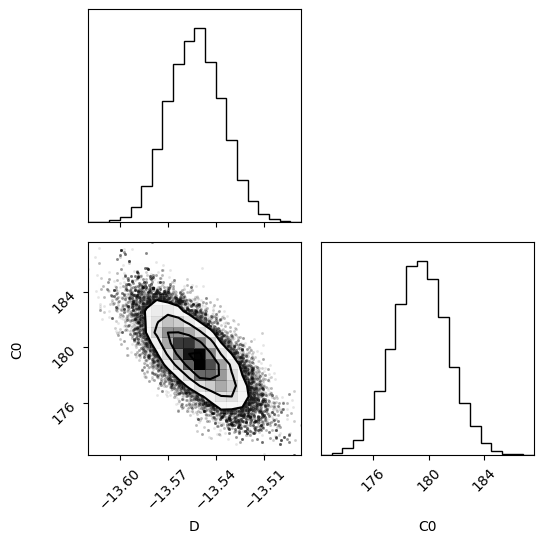

In [13]:
import corner
labels = ['D','C0','lnf']
fig_mh = corner.corner(samples_MH,labels=labels)
plt.tight_layout()

We see a nice correlation between C0 and D. It seems like a 2D Gaussian function, so the LS should be OK. This confirms also the Bootstrap results. 

However, be careful, there is many pitfalls in the MCMC methods, and many tips and tricks to use them efficiently. I won't provide details about this because this is out of the scope of this course.

Here, I want mostly (i) to show you that it can be done quite easily, and (ii) to raise awareness regarding such methods.

Great libraries to check in Python are EMCEE and PyMC3 for instance. Or you can just write your own code as we did !

## To conclude, let's compared the MH MCMC results with the LS and the Bootstrap results.

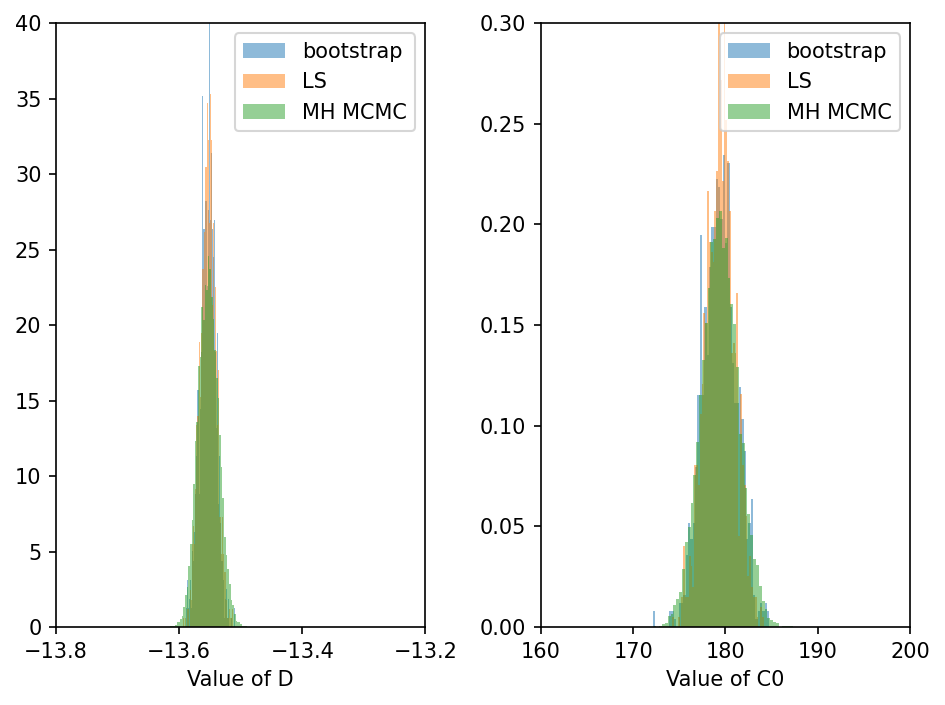

In [14]:
# plotting histograms
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.hist(model_bootstrap_array[:,0].ravel(),density=True, bins=50,label="bootstrap", alpha=0.5)
plt.hist(np.random.normal(loc=popt[0],scale=perr[0],size = n_iter),
         bins = 50,density=True,label="LS", alpha=0.5)
plt.hist(samples_MH[:,0],
                 alpha=0.5,bins=50,density=True, label="MH MCMC")

plt.xlim(-13.8, -13.2)
plt.ylim(0,40)

plt.xlabel("Value of D")
plt.legend()

plt.subplot(1,2,2)
plt.hist(model_bootstrap_array[:,1].ravel(), density=True,bins=50,label="bootstrap", alpha=0.5)
plt.hist(np.random.normal(loc=popt[1],scale=perr[1],size = n_iter),
         bins = 50,density=True,label="LS", alpha=0.5)
plt.hist(samples_MH[:,1],
                 alpha=0.5,bins=50,density=True, label="MH MCMC")

plt.xlim(160, 200)
plt.ylim(0,0.3)

plt.xlabel("Value of C0")
plt.legend()

plt.tight_layout()

# Conclusion

We have estimates for the errors on parameters from the LS algorithm (Gaussian statistics assumption), from bootstrap (no assumption on the shape of errors) and from MCMC (same). All seem to agree in this case. 

Bootstrapping is easy to do in most cases, so do not hesitate to use it to check that your error distribution are indeed Gaussian, or not. Furthermore, you do not need to provide the errors on your data with Bootstrapping. This gives you an advantage, in case you do not know perfectly those data errors.